In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%config InlineBackend.figure_format='retina'
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from keras.layers import TextVectorization, Input, Dense, Embedding, GlobalAveragePooling1D, LSTM, Dropout, GRU, Bidirectional, Conv1D, GlobalMaxPool1D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from utils.helper_function import calculate_result, lossPlot
import statistics

In [29]:
df = pd.read_csv("data/spam_data.csv")
df.columns = ['category', 'message']
df['label'] = df['category'].replace({'ham':0, 'spam':1})
print(df.shape)
df.head()

(5572, 3)


,category,message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5572 non-null   object
 1   message   5572 non-null   object
 2   label     5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [31]:
df.groupby('category').describe()

label                                   
           count mean  std  min  25%  50%  75%  max
category                                           
ham       4825.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
spam       747.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

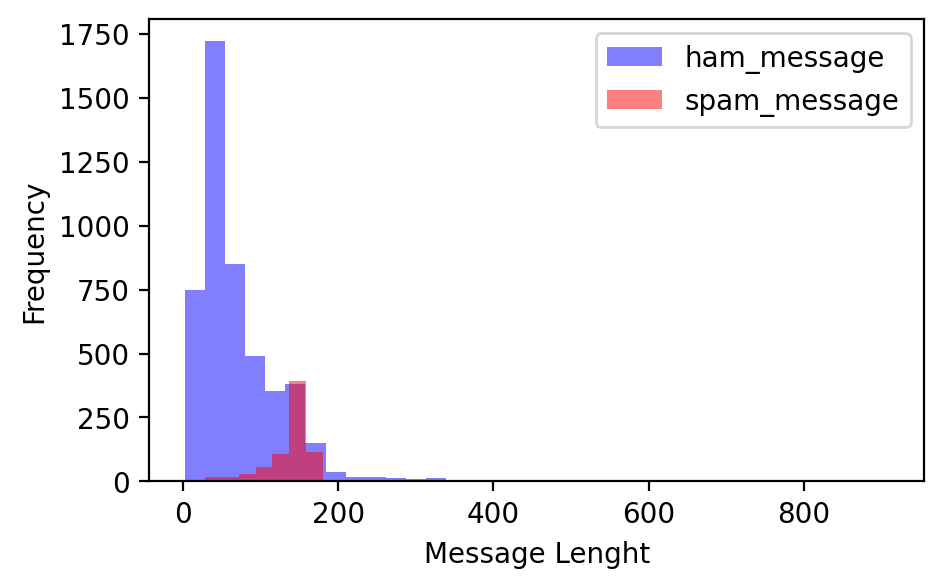

In [32]:
#Plot histogram of lenght text
df['message_len'] = df['message'].apply(lambda x: len(x))

plt.figure(figsize=(5, 3))
df[df['category']=='ham']['message_len'].plot(bins=35, kind="hist", color='blue',
                                             label='ham_message', alpha=0.5)

df[df['category']=='spam']['message_len'].plot(kind="hist", color='red',
                                             label='spam_message', alpha=0.5)

plt.legend()
plt.xlabel("Message Lenght")
plt.show()

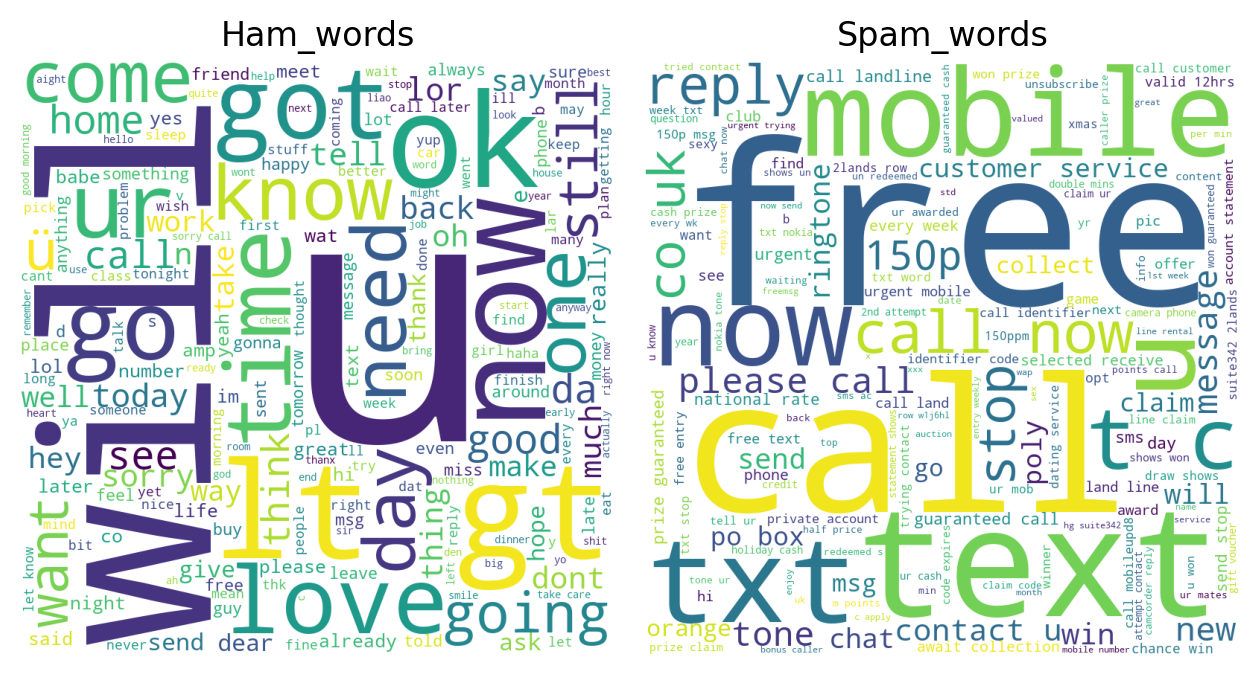

In [33]:
#Plot message wordcloud 
##Create stopword and words
stopwords = list(STOPWORDS)
words = {}

##Clean message function
def clean_text(message):
    clean_message = message.lower().split()
    clean_message = [word for word in clean_message if word not in stopwords]
    clean_message = " ".join(clean_message)
    return clean_message

#Generate ham and spam word
df['message_clean'] = df['message'].apply(clean_text)
words['ham_words'] = " ".join([w for w in df.loc[df['category']=='ham','message_clean']])
words['spam_words'] = " ".join([w for w in df.loc[df['category']=='spam','message_clean']])

#Plot wordcloud
wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10)

for i, (word_type, message) in enumerate(words.items()):
    wc.generate(message)
    # plot the WordCloud image                   
    plt.subplot(1,2,i+1) 
    plt.imshow(wc)
    plt.title(word_type.capitalize())
    plt.axis("off")
    plt.tight_layout()
plt.show()

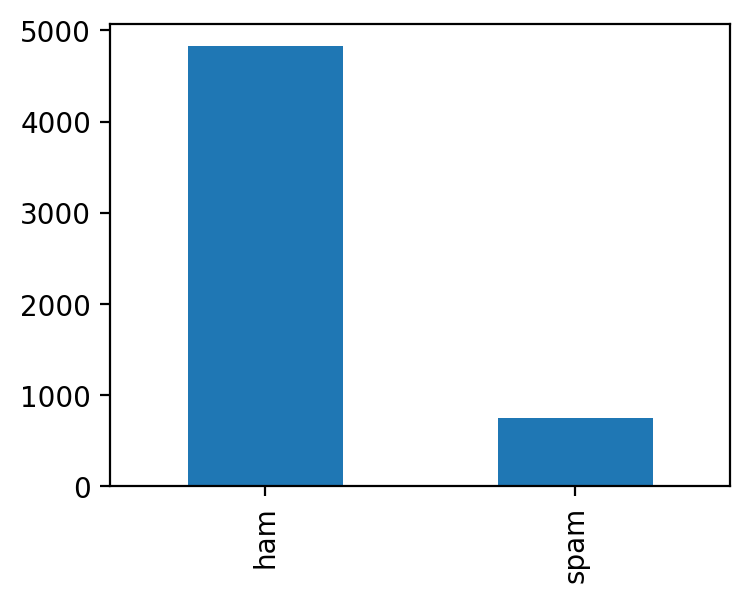

In [34]:
#Plot data unbalance
df['category'].value_counts().plot(kind='bar', figsize=(4,3));

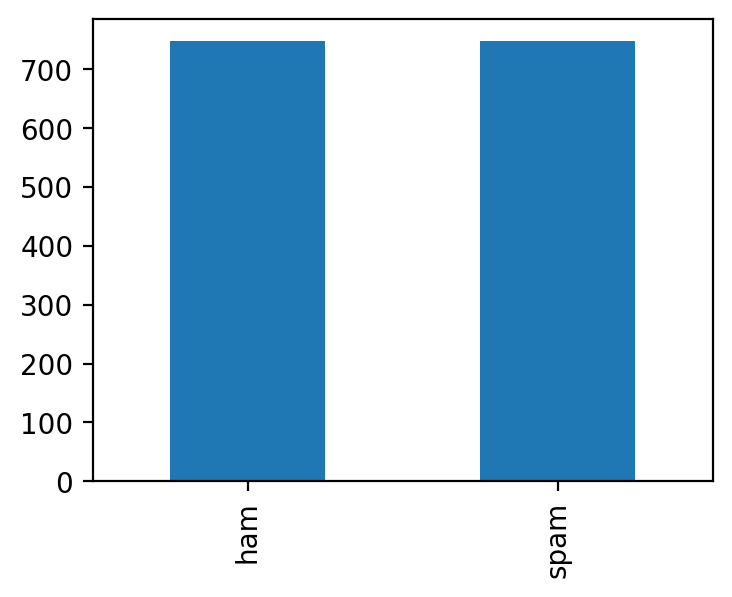

In [35]:
#Random under sampling
df_spam = df[df['category']=='spam']
df_ham_downsample = df[df['category']=='ham'].sample(df_spam.shape[0], random_state=42)
df_balance = pd.concat([df_ham_downsample, df_spam])
df_balance['category'].value_counts().plot(kind='bar', figsize=(4,3));

In [36]:
#Split train test
X = df_balance['message']
y = df_balance['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train shape: {X_train.shape, y_train.shape}")
print(f"Test shape {X_test.shape, y_test.shape}")

Train shape: ((1195,), (1195,))
Test shape ((299,), (299,))


## Model 0: Naive Bayes (baseline)

In [37]:
model_0 = Pipeline([("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())])

model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [38]:
#Model prediction
y_pred = model_0.predict(X_test)

In [39]:
result_0 = calculate_result(y_test, y_pred)
print(result_0)

{'accuracy': 0.946, 'f1_score': 0.946, 'precision': 0.952, 'recall': 0.94}


In [40]:
#result compare
compare_result = pd.DataFrame(result_0, index=['model_0 Naive Bayes (baseline)'])
compare_result

,accuracy,f1_score,precision,recall
model_0 Naive Bayes (baseline),0.946,0.946,0.952,0.94


## Model 1: Simple Dense model

In [41]:
#Check average number of words
word_len = [len(x) for x in X_train.str.split()]
mean = int(statistics.mean(word_len))
mode = int(statistics.mode(word_len))
median = int(statistics.median(word_len))

print(f"Mean : {mean}")
print(f"Mode : {mode}")
print(f"Median : {median}")

Mean : 18
Mode : 27
Median : 21


In [42]:
#Create Text vectorization
max_vocab_lenght = 10000
max_lenght = 38

text_vectorizer = TextVectorization(max_tokens=max_vocab_lenght,
                                    output_sequence_length=max_lenght)

text_vectorizer.adapt(X_train)

2022-10-18 14:46:12.419938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [43]:
#Create Embedding Layer
tf.random.set_seed(42)
embedding = Embedding(input_dim=max_vocab_lenght,
                      output_dim=128,
                      input_length=max_lenght)

#Create model
input = Input(shape=(1,), dtype='string')
x = text_vectorizer(input)
x = embedding(x)
x = GlobalAveragePooling1D()(x)
output = Dense(1, activation='sigmoid')(x)
model_1 = Model(inputs=[input], outputs=[output], name='model_1')

#Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
#Create callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

#Fit model
model_1_history = model_1.fit(X_train,
                              y_train,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              callbacks=[es])

Epoch 1/100
 4/38 [==>...........................] - ETA: 0s - loss: 0.6915 - accuracy: 0.6797 

2022-10-18 14:46:12.824165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 1s 25ms/step - loss: 0.6608 - accuracy: 0.7046 - val_loss: 0.6218 - val_accuracy: 0.6622
Epoch 2/100
 1/38 [..............................] - ETA: 0s - loss: 0.6029 - accuracy: 0.6875

2022-10-18 14:46:13.749188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 1s 20ms/step - loss: 0.5849 - accuracy: 0.7565 - val_loss: 0.5408 - val_accuracy: 0.8261
Epoch 3/100
38/38 [==============================] - 1s 18ms/step - loss: 0.4887 - accuracy: 0.8946 - val_loss: 0.4481 - val_accuracy: 0.8896
Epoch 4/100
38/38 [==============================] - 1s 17ms/step - loss: 0.3893 - accuracy: 0.9264 - val_loss: 0.3639 - val_accuracy: 0.9097
Epoch 5/100
38/38 [==============================] - 1s 17ms/step - loss: 0.3052 - accuracy: 0.9331 - val_loss: 0.3018 - val_accuracy: 0.9197
Epoch 6/100
38/38 [==============================] - 1s 17ms/step - loss: 0.2443 - accuracy: 0.9464 - val_loss: 0.2587 - val_accuracy: 0.9298
Epoch 7/100
38/38 [==============================] - 1s 16ms/step - loss: 0.2012 - accuracy: 0.9607 - val_loss: 0.2274 - val_accuracy: 0.9365
Epoch 8/100
38/38 [==============================] - 1s 16ms/step - loss: 0.1688 - accuracy: 0.9632 - val_loss: 0.2053 - val_accuracy: 0.9431
Epoch 9/100
38/38 

In [44]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 38)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 38, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

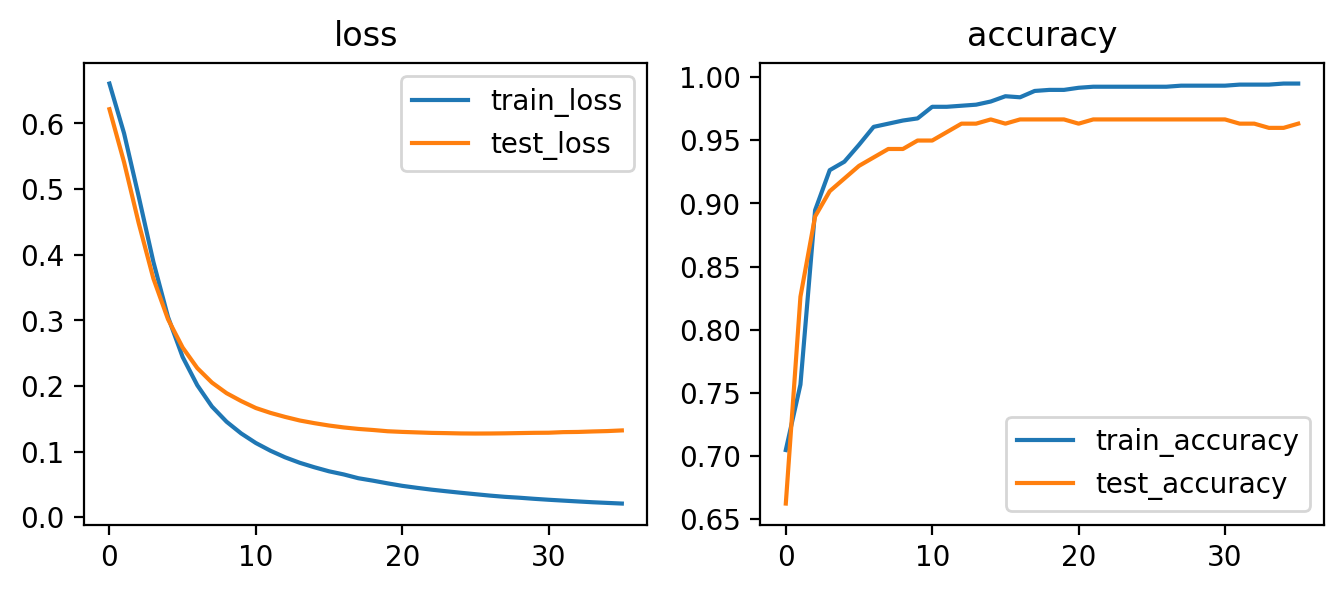

In [45]:
lossPlot(model_1_history)

In [46]:
#Model predict
y_pred = model_1.predict(X_test, verbose=0)
y_pred = np.squeeze(np.round(y_pred))

2022-10-18 14:46:36.085041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [47]:
#Calculate result
result_1 = calculate_result(y_test, y_pred)
print(result_1)

{'accuracy': 0.967, 'f1_score': 0.966, 'precision': 0.993, 'recall': 0.94}


In [48]:
#Compare result
compare_result1 = pd.concat([compare_result, pd.DataFrame(result_1, index=['model_1 Simple Dense model'])])
compare_result1

,accuracy,f1_score,precision,recall
model_0 Naive Bayes (baseline),0.946,0.946,0.952,0.94
model_1 Simple Dense model,0.967,0.966,0.993,0.94


## Model2 LSTM

In [67]:
#Create Embedding Layer
tf.random.set_seed(42)
embedding = Embedding(input_dim=max_vocab_lenght,
                      output_dim=128,
                      input_length=max_lenght)

#Create model
input = Input(shape=(1,), dtype='string')
x = text_vectorizer(input)
x = embedding(x)
x = LSTM(64)(x)
x = Dropout(0.4)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model_2 = Model(inputs=[input], outputs=[output])

#Compile model
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
#Create callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)

#Fit model
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              callbacks=[es])

Epoch 1/100


2022-10-18 14:59:21.483197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 14:59:21.671564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/38 [..............................] - ETA: 1:00 - loss: 0.6912 - accuracy: 0.5938

2022-10-18 14:59:21.916629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7063

2022-10-18 14:59:23.775842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 14:59:23.845508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 4s 57ms/step - loss: 0.5554 - accuracy: 0.7063 - val_loss: 0.3584 - val_accuracy: 0.8997
Epoch 2/100
38/38 [==============================] - 1s 31ms/step - loss: 0.1767 - accuracy: 0.9556 - val_loss: 0.2470 - val_accuracy: 0.9398
Epoch 3/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0858 - accuracy: 0.9841 - val_loss: 0.2552 - val_accuracy: 0.9398
Epoch 4/100
38/38 [==============================] - 1s 25ms/step - loss: 0.0638 - accuracy: 0.9891 - val_loss: 0.2925 - val_accuracy: 0.9365
Epoch 5/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0384 - accuracy: 0.9925 - val_loss: 0.1786 - val_accuracy: 0.9532
Epoch 6/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0222 - accuracy: 0.9967 - val_loss: 0.5269 - val_accuracy: 0.9231
Epoch 7/100
38/38 [==============================] - 1s 24ms/step - loss: 0.0111 - accuracy: 0.9983 - val_loss: 0.6380 - val_accuracy: 0.9231
Epoch 8/100
38/38 

In [68]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 38)               0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 38, 32)            320000    
                                                                 
 lstm_4 (LSTM)               (None, 128)               82432     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 20)                2580      
                                                           

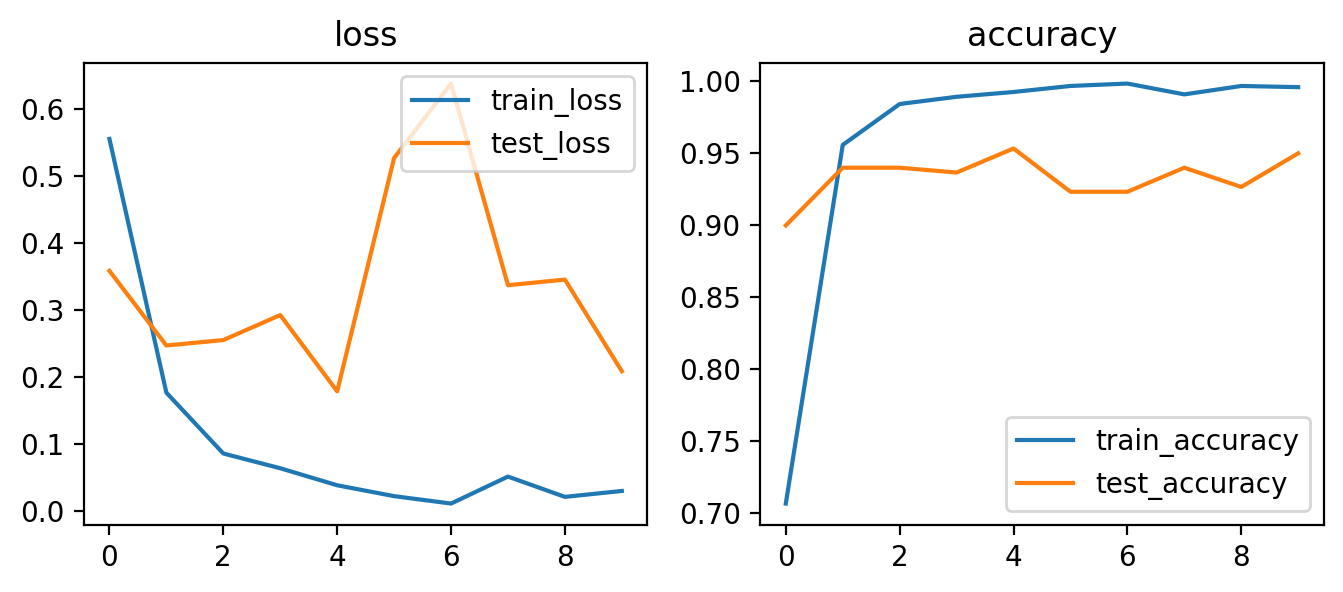

In [69]:
lossPlot(model_2_history)

In [70]:
#Model predict
y_pred = model_2.predict(X_test, verbose=0)
y_pred = np.squeeze(np.round(y_pred))

2022-10-18 14:59:33.513411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 14:59:33.564507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [71]:
#Calculate result
result_2 = calculate_result(y_test, y_pred)
print(result_2)

{'accuracy': 0.953, 'f1_score': 0.953, 'precision': 0.959, 'recall': 0.946}


In [72]:
#Compare result
compare_result2 = pd.concat([compare_result1, pd.DataFrame(result_2, index=['model_2 LSTM'])])
compare_result2

,accuracy,f1_score,precision,recall
model_0 Naive Bayes (baseline),0.946,0.946,0.952,0.940
model_1 Simple Dense model,0.967,0.966,0.993,0.940
model_2 LSTM,0.953,0.953,0.959,0.946


## Model3 GRU

In [76]:
#Create Embedding Layer
tf.random.set_seed(42)
embedding = Embedding(input_dim=max_vocab_lenght,
                      output_dim=128,
                      input_length=max_lenght)

#Create model
input = Input(shape=(1,), dtype='string')
x = text_vectorizer(input)
x = embedding(x)
x = GRU(64)(x)
output = Dense(1, activation='sigmoid')(x)
model_3 = Model(inputs=[input], outputs=[output])

#Compile model
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
#Create callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

#Fit model
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              callbacks=[es])

Epoch 1/100


2022-10-18 15:09:31.527111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:09:31.694333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/38 [..............................] - ETA: 55s - loss: 0.6974 - accuracy: 0.3750

2022-10-18 15:09:31.890482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.4962

2022-10-18 15:09:33.738405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:09:33.800876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 4s 57ms/step - loss: 0.6960 - accuracy: 0.4962 - val_loss: 0.6956 - val_accuracy: 0.5017
Epoch 2/100
38/38 [==============================] - 1s 34ms/step - loss: 0.6918 - accuracy: 0.5188 - val_loss: 0.6962 - val_accuracy: 0.5050
Epoch 3/100
38/38 [==============================] - 1s 31ms/step - loss: 0.6891 - accuracy: 0.5138 - val_loss: 0.6374 - val_accuracy: 0.5485
Epoch 4/100
38/38 [==============================] - 1s 29ms/step - loss: 0.3318 - accuracy: 0.8745 - val_loss: 0.3951 - val_accuracy: 0.8896
Epoch 5/100
38/38 [==============================] - 1s 27ms/step - loss: 0.2720 - accuracy: 0.9305 - val_loss: 0.4539 - val_accuracy: 0.8528
Epoch 6/100
38/38 [==============================] - 1s 27ms/step - loss: 0.2421 - accuracy: 0.9339 - val_loss: 0.4098 - val_accuracy: 0.8662
Epoch 7/100
38/38 [==============================] - 1s 26ms/step - loss: 0.1961 - accuracy: 0.9490 - val_loss: 0.4402 - val_accuracy: 0.8629
Epoch 8/100
38/38 

In [77]:
model_3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 38)               0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 38, 128)           1280000   
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

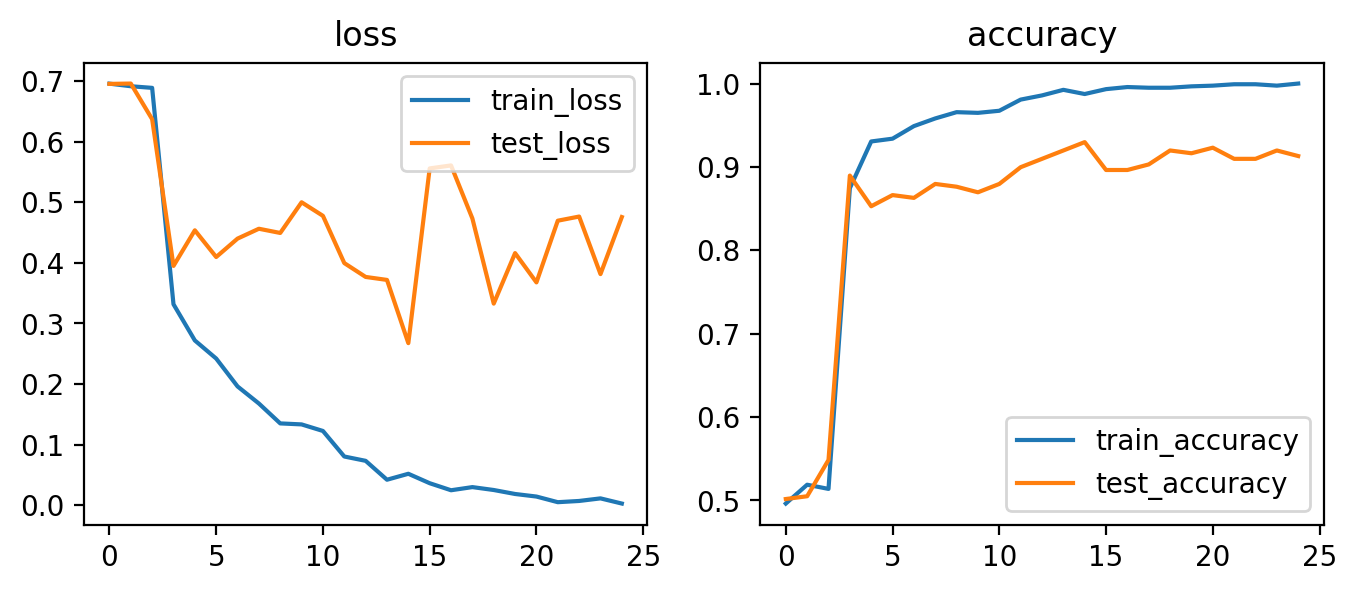

In [78]:
lossPlot(model_3_history)

In [79]:
#Model predict
y_pred = model_3.predict(X_test, verbose=0)
y_pred = np.squeeze(np.round(y_pred))

2022-10-18 15:11:37.465028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:11:37.509912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [80]:
#Calculate result
result_3 = calculate_result(y_test, y_pred)
print(result_3)

{'accuracy': 0.93, 'f1_score': 0.93, 'precision': 0.927, 'recall': 0.933}


In [81]:
#Compare result
compare_result3 = pd.concat([compare_result2, pd.DataFrame(result_3, index=['model_3 GRU'])])
compare_result3

,accuracy,f1_score,precision,recall
model_0 Naive Bayes (baseline),0.946,0.946,0.952,0.940
model_1 Simple Dense model,0.967,0.966,0.993,0.940
model_2 LSTM,0.953,0.953,0.959,0.946
model_3 GRU,0.930,0.930,0.927,0.933


## Model4 Bidirectonal RNN model

In [82]:
#Create Embedding Layer
tf.random.set_seed(42)
embedding = Embedding(input_dim=max_vocab_lenght,
                      output_dim=128,
                      input_length=max_lenght)

#Create model
input = Input(shape=(1,), dtype='string')
x = text_vectorizer(input)
x = embedding(x)
x = Bidirectional(LSTM(64))(x)
output = Dense(1, activation='sigmoid')(x)
model_4 = Model(inputs=[input], outputs=[output])

#Compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
#Create callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

#Fit model
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              callbacks=[es])

Epoch 1/100


2022-10-18 15:14:43.720680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:14:43.985738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:14:44.005533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:14:44.256443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:14:44.281276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.7908

2022-10-18 15:14:47.033837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:14:47.129619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:14:47.142329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 6s 87ms/step - loss: 0.4546 - accuracy: 0.7908 - val_loss: 0.2290 - val_accuracy: 0.9097
Epoch 2/100
38/38 [==============================] - 2s 53ms/step - loss: 0.1044 - accuracy: 0.9649 - val_loss: 0.1686 - val_accuracy: 0.9465
Epoch 3/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0460 - accuracy: 0.9883 - val_loss: 0.1337 - val_accuracy: 0.9565
Epoch 4/100
38/38 [==============================] - 2s 41ms/step - loss: 0.0376 - accuracy: 0.9891 - val_loss: 0.1599 - val_accuracy: 0.9465
Epoch 5/100
38/38 [==============================] - 1s 39ms/step - loss: 0.0192 - accuracy: 0.9950 - val_loss: 0.1878 - val_accuracy: 0.9365
Epoch 6/100
38/38 [==============================] - 2s 41ms/step - loss: 0.0120 - accuracy: 0.9975 - val_loss: 0.1452 - val_accuracy: 0.9565
Epoch 7/100
38/38 [==============================] - 2s 41ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.1701 - val_accuracy: 0.9599
Epoch 8/100
38/38 

In [83]:
model_4.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 38)               0         
 ectorization)                                                   
                                                                 
 embedding_10 (Embedding)    (None, 38, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

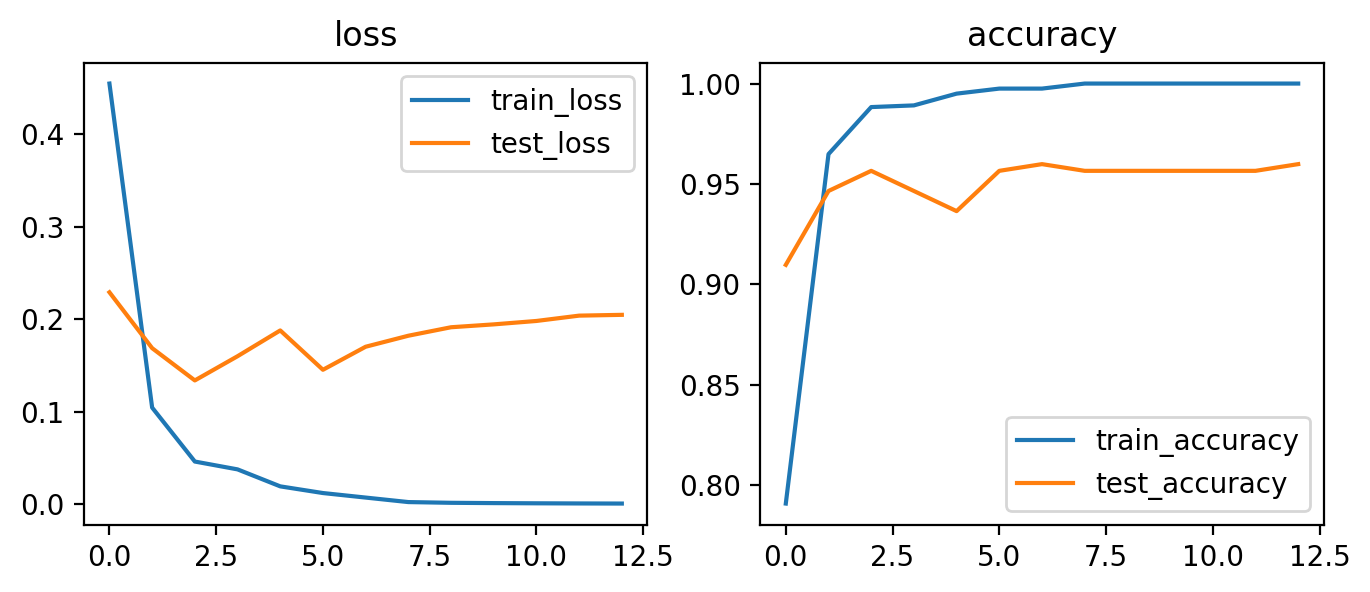

In [84]:
lossPlot(model_4_history)

In [85]:
#Model predict
y_pred = model_4.predict(X_test, verbose=0)
y_pred = np.squeeze(np.round(y_pred))

2022-10-18 15:16:05.081230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:16:05.161343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:16:05.174675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [86]:
#Calculate result
result_4 = calculate_result(y_test, y_pred)
print(result_4)

{'accuracy': 0.957, 'f1_score': 0.955, 'precision': 0.986, 'recall': 0.926}


In [87]:
#Compare result
compare_result4 = pd.concat([compare_result3, pd.DataFrame(result_4, index=['model_4 Bidirectional RNN'])])
compare_result4

,accuracy,f1_score,precision,recall
model_0 Naive Bayes (baseline),0.946,0.946,0.952,0.940
model_1 Simple Dense model,0.967,0.966,0.993,0.940
model_2 LSTM,0.953,0.953,0.959,0.946
model_3 GRU,0.930,0.930,0.927,0.933
model_4 Bidirectional RNN,0.957,0.955,0.986,0.926


## Model5 Con1D

In [97]:
#Create Embedding Layer
tf.random.set_seed(42)
embedding = Embedding(input_dim=max_vocab_lenght,
                      output_dim=128,
                      input_length=max_lenght)

#Create model
input = Input(shape=(1,), dtype='string')
x = text_vectorizer(input)
x = embedding(x)
x = Conv1D(32, 5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
output = Dense(1, activation='sigmoid')(x)
model_5 = Model(inputs=[input], outputs=[output])


#Compile model
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
#Create callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

#Fit model
model_5_history = model_5.fit(X_train,
                              y_train,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              callbacks=[es])

Epoch 1/100


2022-10-18 15:24:40.641957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.7615

2022-10-18 15:24:42.781480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 3s 58ms/step - loss: 0.6300 - accuracy: 0.7615 - val_loss: 0.5434 - val_accuracy: 0.9130
Epoch 2/100
38/38 [==============================] - 1s 38ms/step - loss: 0.3839 - accuracy: 0.9715 - val_loss: 0.2934 - val_accuracy: 0.9264
Epoch 3/100
38/38 [==============================] - 1s 27ms/step - loss: 0.1417 - accuracy: 0.9816 - val_loss: 0.1730 - val_accuracy: 0.9431
Epoch 4/100
38/38 [==============================] - 1s 24ms/step - loss: 0.0590 - accuracy: 0.9891 - val_loss: 0.1483 - val_accuracy: 0.9431
Epoch 5/100
38/38 [==============================] - 1s 22ms/step - loss: 0.0327 - accuracy: 0.9933 - val_loss: 0.1391 - val_accuracy: 0.9498
Epoch 6/100
38/38 [==============================] - 1s 22ms/step - loss: 0.0219 - accuracy: 0.9950 - val_loss: 0.1348 - val_accuracy: 0.9565
Epoch 7/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0161 - accuracy: 0.9950 - val_loss: 0.1356 - val_accuracy: 0.9565
Epoch 8/100
38/38 

In [98]:
model_5.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 38)               0         
 ectorization)                                                   
                                                                 
 embedding_18 (Embedding)    (None, 38, 128)           1280000   
                                                                 
 conv1d_6 (Conv1D)           (None, 34, 32)            20512     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_19 (Dense)            (None, 1)                 33 

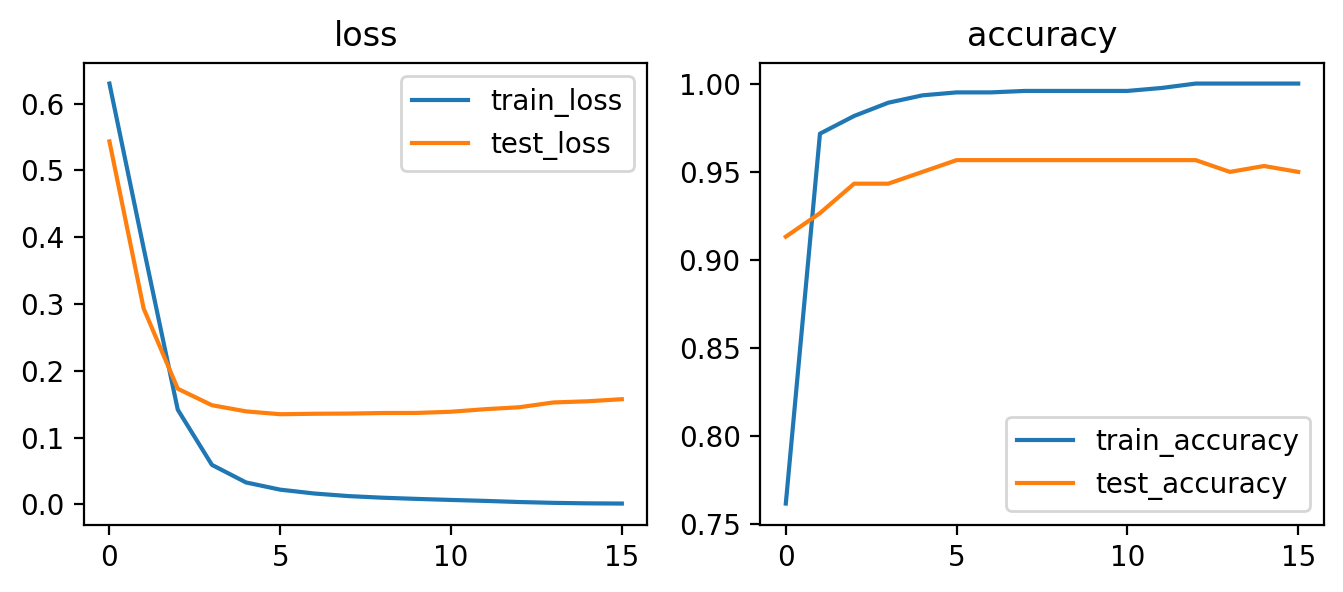

In [99]:
lossPlot(model_5_history)

In [100]:
#Model predict
y_pred = model_5.predict(X_test, verbose=0)
y_pred = np.squeeze(np.round(y_pred))

2022-10-18 15:25:34.889852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [101]:
#Calculate result
result_5 = calculate_result(y_test, y_pred)
print(result_5)

{'accuracy': 0.957, 'f1_score': 0.956, 'precision': 0.972, 'recall': 0.94}


In [102]:
#Compare result
compare_result5 = pd.concat([compare_result4, pd.DataFrame(result_5, index=['model_5 Conv1D'])])
compare_result5

,accuracy,f1_score,precision,recall
model_0 Naive Bayes (baseline),0.946,0.946,0.952,0.940
model_1 Simple Dense model,0.967,0.966,0.993,0.940
model_2 LSTM,0.953,0.953,0.959,0.946
model_3 GRU,0.930,0.930,0.927,0.933
model_4 Bidirectional RNN,0.957,0.955,0.986,0.926
model_5 Conv1D,0.957,0.956,0.972,0.940


## Model6 Pretrained Sentence Encoder

In [108]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], 
                                        dtype=tf.string, 
                                        trainable=False, 
                                        name="USE") 

2022-10-18 15:42:06.178490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:42:08.343394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [125]:
#Create Embedding Layer
tf.random.set_seed(42)

#Create model
input = Input(shape=(), dtype=tf.string)
x = sentence_encoder_layer(input)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)
model_6 = Model(inputs=[input], outputs=[output])

#Compile model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
#Create callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

#Fit model
model_6_history = model_6.fit(X_train,
                              y_train,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              callbacks=[es])

Epoch 1/100


2022-10-18 15:55:19.727494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 15:55:20.356763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.7916

2022-10-18 15:55:27.513758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 12s 271ms/step - loss: 0.5902 - accuracy: 0.7916 - val_loss: 0.4592 - val_accuracy: 0.9431
Epoch 2/100
38/38 [==============================] - 5s 135ms/step - loss: 0.3367 - accuracy: 0.9523 - val_loss: 0.2492 - val_accuracy: 0.9666
Epoch 3/100
38/38 [==============================] - 4s 115ms/step - loss: 0.1908 - accuracy: 0.9623 - val_loss: 0.1662 - val_accuracy: 0.9766
Epoch 4/100
38/38 [==============================] - 4s 116ms/step - loss: 0.1335 - accuracy: 0.9674 - val_loss: 0.1346 - val_accuracy: 0.9732
Epoch 5/100
38/38 [==============================] - 4s 112ms/step - loss: 0.1063 - accuracy: 0.9766 - val_loss: 0.1191 - val_accuracy: 0.9732
Epoch 6/100
38/38 [==============================] - 4s 109ms/step - loss: 0.0902 - accuracy: 0.9749 - val_loss: 0.1118 - val_accuracy: 0.9732
Epoch 7/100
38/38 [==============================] - 4s 104ms/step - loss: 0.0780 - accuracy: 0.9791 - val_loss: 0.1076 - val_accuracy: 0.9766
Epoch 8/10

In [126]:
model_6.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_25 (Dense)            (None, 64)                32832     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


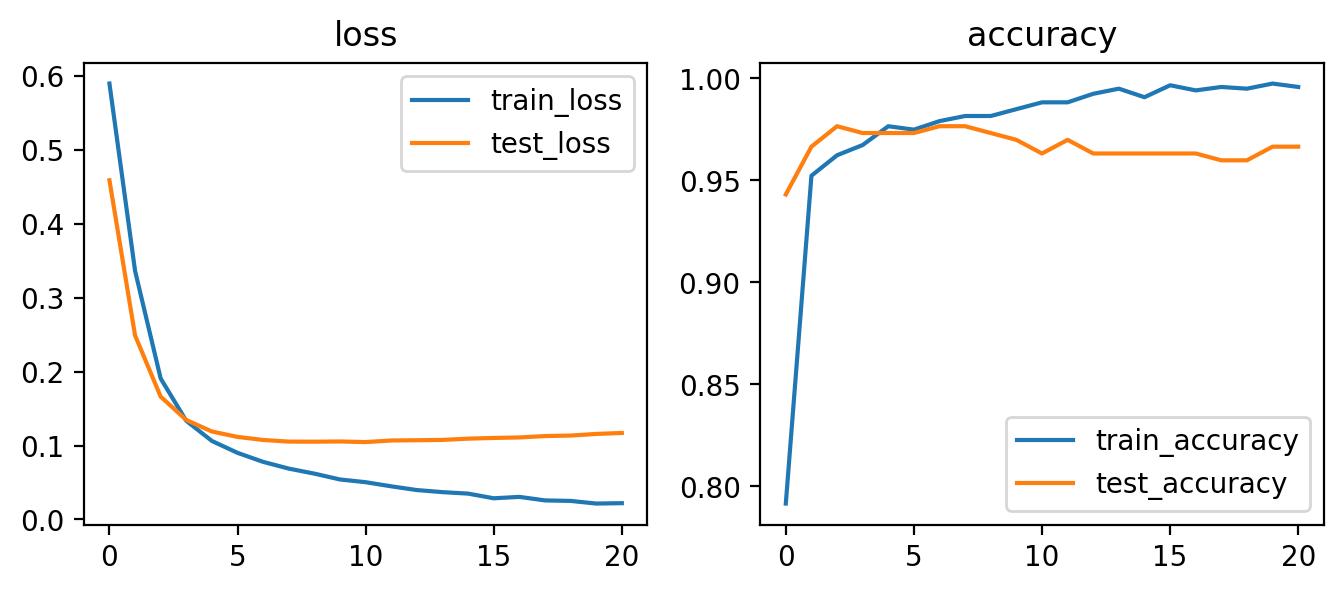

In [127]:
lossPlot(model_6_history)

In [128]:
#Model predict
y_pred = model_6.predict(X_test, verbose=0)
y_pred = np.squeeze(np.round(y_pred))

2022-10-18 15:56:44.922172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [129]:
#Calculate result
result_6 = calculate_result(y_test, y_pred)
print(result_6)

{'accuracy': 0.963, 'f1_score': 0.963, 'precision': 0.973, 'recall': 0.953}


In [130]:
#Compare result
compare_result6 = pd.concat([compare_result5, pd.DataFrame(result_6, index=['model_6 Pretrained Sentence Encoder'])])
compare_result6

,accuracy,f1_score,precision,recall
model_0 Naive Bayes (baseline),0.946,0.946,0.952,0.940
model_1 Simple Dense model,0.967,0.966,0.993,0.940
model_2 LSTM,0.953,0.953,0.959,0.946
model_3 GRU,0.930,0.930,0.927,0.933
model_4 Bidirectional RNN,0.957,0.955,0.986,0.926
model_5 Conv1D,0.957,0.956,0.972,0.940
model_6 Pretrained Sentence Encoder,0.963,0.963,0.973,0.953
